In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "rnn_layers": hp.choice('rnn_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False]),
    "conv_layers": hp.choice('conv_layers', [[64, 128, 64], [128, 256, 128], [256, 512, 256]]),
    "kss": hp.choice('kss', [[11, 9, 7], [9, 7, 5], [7, 5, 3]])
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x1475bf3b1c8>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x1475bf3b808>,
 'lr': <hyperopt.pyll.base.Apply at 0x1475bf3bf48>,
 'epochs': <hyperopt.pyll.base.Apply at 0x1475bf3c588>,
 'patience': <hyperopt.pyll.base.Apply at 0x1475bf3cb08>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x1475bf24148>,
 'rnn_layers': <hyperopt.pyll.base.Apply at 0x1475bf24988>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x1475bf24f08>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x1475bf294c8>,
 'conv_layers': <hyperopt.pyll.base.Apply at 0x1475bf2e288>,
 'kss': <hyperopt.pyll.base.Apply at 0x1475bf2ef88>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

183

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = LSTM_FCN
        k = {
            'rnn_layers': params['rnn_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional'],
            'conv_layers': params['conv_layers'],
            'kss': params['kss']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 100, 'hidden_size': 200, 'kss': (11, 9, 7), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000146BEB4C1F8>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 60}
LSTM_FCN                                                                                                               
  0%|                                                                           | 0/30 [00:30<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,1.609586,1.600744,0.571932,00:10
1,1.528286,1.534968,0.572994,00:09
2,1.436985,1.439766,0.584673,00:09
3,1.305096,1.255828,0.617972,00:09
4,1.116585,1.040235,0.654746,00:09
5,1.038471,0.999831,0.657111,00:09
6,0.999965,0.986695,0.657883,00:09
7,0.975167,0.969137,0.659814,00:09
8,0.953056,0.957242,0.664157,00:09
9,0.935859,0.936893,0.668452,00:09


No improvement since epoch 15: early stopping                                                                          
  0%|                                                                           | 0/30 [04:39<?, ?trial/s, best loss=?]

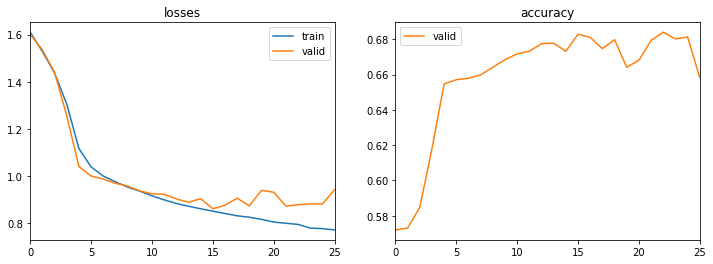

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x00000146BEB4C438>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 60}
LSTM_FCN                                                                                                               
  3%|█▌                                            | 1/30 [05:09<2:15:15, 279.83s/trial, best loss: 0.9413773417472839]

epoch,train_loss,valid_loss,accuracy,time
0,1.007434,0.984211,0.654650,00:08
1,0.917484,0.928891,0.662227,00:07
2,0.889587,0.894171,0.664012,00:07
3,0.844602,0.836002,0.687467,00:07
4,0.804276,0.901244,0.670238,00:07
5,0.780167,0.943023,0.672844,00:07
6,0.743016,1.011416,0.665508,00:07
7,0.705630,0.983782,0.628252,00:07
8,0.664711,1.063802,0.648714,00:07


No improvement since epoch 3: early stopping                                                                           
  3%|█▌                                            | 1/30 [06:17<2:15:15, 279.83s/trial, best loss: 0.9413773417472839]

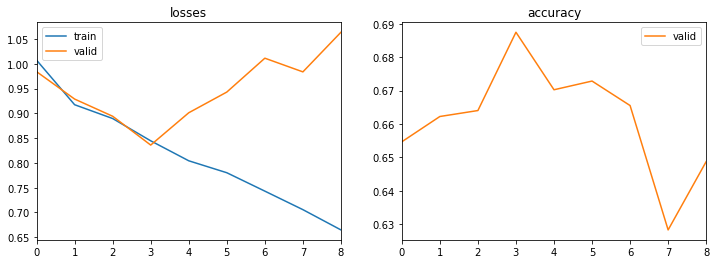

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function RMSProp at 0x00000146BEB4C1F8>, 'patience': 10, 'rnn_layers': 4, 'time_steps': 90}
LSTM_FCN                                                                                                               
  7%|███                                           | 2/30 [06:46<1:45:08, 225.30s/trial, best loss: 0.9413773417472839]

epoch,train_loss,valid_loss,accuracy,time
0,0.911007,0.905428,0.668308,00:10
1,0.875177,0.882450,0.684330,00:10
2,0.859314,0.960305,0.677477,00:10
3,0.821057,1.001725,0.661358,00:10
4,0.798824,1.182632,0.581246,00:10
5,0.791547,1.023540,0.681338,00:10
6,0.751857,1.124833,0.653106,00:10
7,0.716501,1.410786,0.665364,00:10
8,0.709236,1.645518,0.446504,00:10
9,0.657668,1.934820,0.661068,00:10


No improvement since epoch 1: early stopping                                                                           
  7%|███                                           | 2/30 [08:55<1:45:08, 225.30s/trial, best loss: 0.9413773417472839]

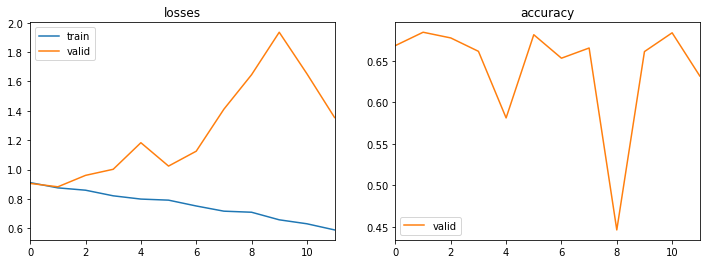

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 100, 'hidden_size': 200, 'kss': (11, 9, 7), 'lr': 0.01, 'optimizer': <function RMSProp at 0x00000146BEB4C1F8>, 'patience': 10, 'rnn_layers': 4, 'time_steps': 60}
LSTM_FCN                                                                                                               
 10%|████▌                                         | 3/30 [09:23<1:32:14, 204.97s/trial, best loss: 0.9413773417472839]

epoch,train_loss,valid_loss,accuracy,time
0,0.874669,0.933815,0.672844,00:07
1,0.821135,0.970471,0.656049,00:07
2,0.778914,1.073636,0.664109,00:07
3,0.743672,0.964415,0.668887,00:07
4,0.716421,1.021410,0.653057,00:07
5,0.678704,1.072390,0.651416,00:07
6,0.658951,1.227804,0.652189,00:07
7,0.621338,1.515096,0.605087,00:07
8,0.584029,1.317487,0.612277,00:07
9,0.558437,1.172018,0.643260,00:07


No improvement since epoch 0: early stopping                                                                           
 10%|████▌                                         | 3/30 [10:49<1:32:14, 204.97s/trial, best loss: 0.9413773417472839]

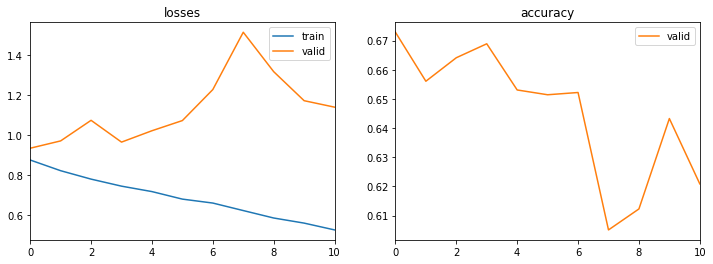

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 200, 'kss': (11, 9, 7), 'lr': 0.0001, 'optimizer': <function Adam at 0x00000146BEB4C438>, 'patience': 5, 'rnn_layers': 4, 'time_steps': 60}
LSTM_FCN                                                                                                               
 13%|██████▏                                       | 4/30 [11:18<1:16:59, 177.66s/trial, best loss: 0.9413773417472839]

epoch,train_loss,valid_loss,accuracy,time
0,1.569211,1.576370,0.561459,00:09
1,1.395170,1.399372,0.588196,00:09
2,1.055840,1.009499,0.656725,00:09
3,0.977834,0.973573,0.660489,00:09
4,0.944134,0.949796,0.664929,00:09
5,0.920276,0.914791,0.673037,00:10
6,0.891749,0.904208,0.673520,00:10
7,0.868975,0.903381,0.672265,00:10
8,0.846802,0.864324,0.681096,00:10
9,0.827874,0.864203,0.678780,00:10


No improvement since epoch 12: early stopping                                                                          
 13%|██████▏                                       | 4/30 [14:18<1:16:59, 177.66s/trial, best loss: 0.9413773417472839]

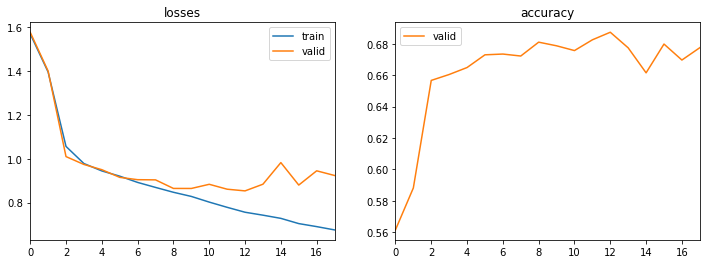

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function Adam at 0x00000146BEB4C438>, 'patience': 10, 'rnn_layers': 5, 'time_steps': 60}
LSTM_FCN                                                                                                               
 17%|███████▋                                      | 5/30 [14:48<1:18:02, 187.28s/trial, best loss: 0.9233667254447937]

epoch,train_loss,valid_loss,accuracy,time
0,0.879987,0.932706,0.672120,00:20
1,0.833135,1.035308,0.660682,00:21
2,0.778755,1.082519,0.638772,00:22
3,0.722265,0.965744,0.661551,00:22
4,0.696614,1.077016,0.661068,00:22
5,0.671354,0.982366,0.641137,00:21
6,0.636966,1.133910,0.667728,00:21
7,0.664415,1.178391,0.652237,00:22
8,0.628611,1.109881,0.663723,00:22
9,1.712083,4.908280,0.665508,00:22


No improvement since epoch 0: early stopping                                                                           
 17%|███████▋                                      | 5/30 [18:50<1:18:02, 187.28s/trial, best loss: 0.9233667254447937]

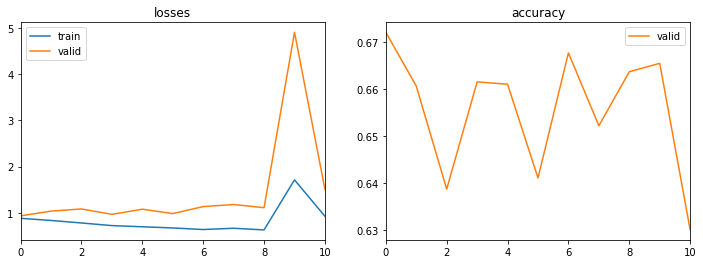

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 10, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x00000146BEB4C438>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 30}
LSTM_FCN                                                                                                               
 20%|█████████▏                                    | 6/30 [19:23<1:25:01, 212.55s/trial, best loss: 0.9233667254447937]

epoch,train_loss,valid_loss,accuracy,time
0,1.058869,0.975493,0.661744,00:03
1,0.925054,0.955589,0.670190,00:03
2,0.873862,0.949318,0.665074,00:03
3,0.825273,0.961463,0.671300,00:03
4,0.777846,1.063912,0.673037,00:03
5,0.728603,1.042756,0.624391,00:03
6,0.678002,1.024953,0.659138,00:03
7,0.647046,1.066467,0.655470,00:03
8,0.615317,1.049578,0.653443,00:03
9,0.612604,1.070108,0.655229,00:03


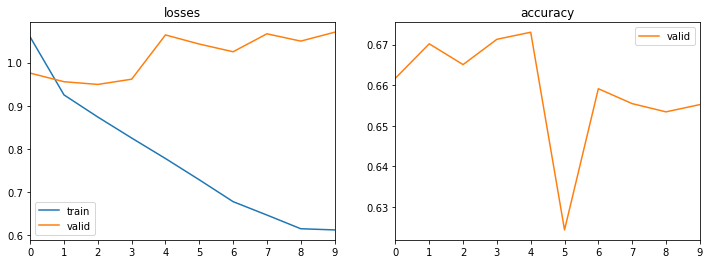

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 60}
LSTM_FCN                                                                                                               
 23%|██████████▋                                   | 7/30 [20:30<1:04:58, 169.51s/trial, best loss: 0.9233667254447937]

epoch,train_loss,valid_loss,accuracy,time
0,1.172544,1.128980,0.664543,00:29
1,1.097747,1.093830,0.664543,00:30
2,1.056666,1.073987,0.662999,00:28
3,1.015922,1.040310,0.659331,00:29
4,0.967090,0.998117,0.657256,00:29
5,0.940170,0.967785,0.658462,00:29
6,0.935715,0.949206,0.661792,00:29
7,0.921088,0.931346,0.665701,00:29
8,0.911455,0.919166,0.669128,00:29
9,0.897931,0.905076,0.673520,00:29


No improvement since epoch 21: early stopping                                                                          
 23%|██████████▋                                   | 7/30 [33:52<1:04:58, 169.51s/trial, best loss: 0.9233667254447937]

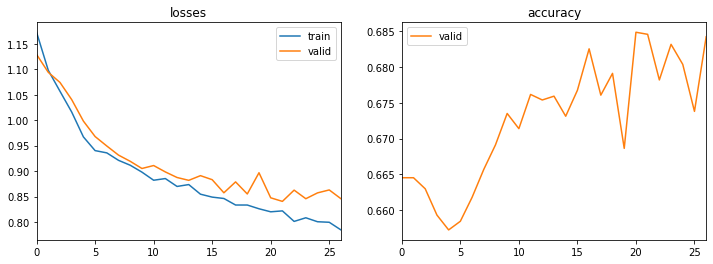

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 10, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 30}
LSTM_FCN                                                                                                               
 27%|████████████▎                                 | 8/30 [34:22<2:15:07, 368.51s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,1.101051,1.089118,0.664543,00:11
1,0.997388,1.020327,0.660103,00:11
2,0.970452,0.990438,0.656966,00:11
3,0.950114,0.971768,0.658607,00:11
4,0.947383,0.965448,0.659331,00:11
5,0.933446,0.955249,0.663288,00:11
6,0.944026,0.952089,0.664591,00:11
7,0.936377,0.953296,0.663288,00:11
8,0.933853,0.950900,0.664591,00:11
9,0.936091,0.950134,0.664929,00:11


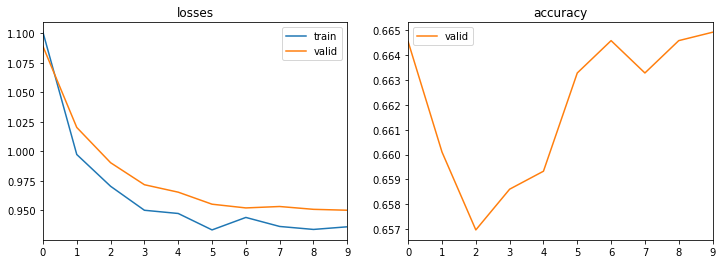

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 10, 'hidden_size': 200, 'kss': (11, 9, 7), 'lr': 0.1, 'optimizer': <function RMSProp at 0x00000146BEB4C1F8>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 30}
LSTM_FCN                                                                                                               
 30%|█████████████▊                                | 9/30 [36:48<1:45:38, 301.83s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,1.036674,1.049825,0.663337,00:03
1,1.006054,1.031940,0.661889,00:03
2,0.978578,1.315115,0.608465,00:03
3,0.971336,0.958614,0.663288,00:03
4,0.959490,0.986696,0.669176,00:03
5,1.345291,1.019567,0.683316,00:03
6,0.966772,0.909571,0.674871,00:03
7,0.878461,0.965605,0.672940,00:03
8,0.847644,0.963749,0.674871,00:03
9,0.835253,0.966271,0.672168,00:03


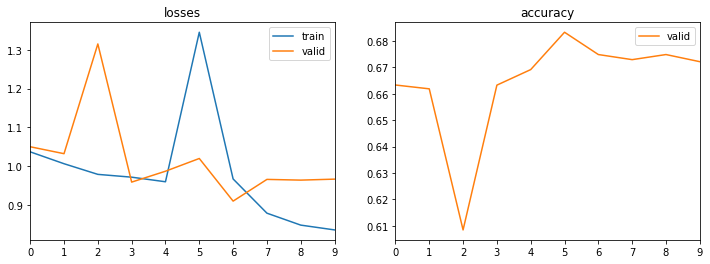

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 100, 'hidden_size': 100, 'kss': (11, 9, 7), 'lr': 0.001, 'optimizer': <function Adam at 0x00000146BEB4C438>, 'patience': 5, 'rnn_layers': 1, 'time_steps': 30}
LSTM_FCN                                                                                                               
 33%|███████████████                              | 10/30 [37:51<1:16:50, 230.51s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,1.379848,1.312677,0.604797,00:08
1,1.105219,1.046902,0.648762,00:08
2,0.977196,0.961007,0.667535,00:08
3,0.928869,0.959488,0.666763,00:08
4,0.899088,0.951983,0.677815,00:08
5,0.874132,0.947902,0.669031,00:08
6,0.849737,0.954135,0.665701,00:08
7,0.819655,0.963201,0.660538,00:08
8,0.790997,1.001476,0.664833,00:08
9,0.766285,1.048121,0.623088,00:08


No improvement since epoch 5: early stopping                                                                           
 33%|███████████████                              | 10/30 [39:26<1:16:50, 230.51s/trial, best loss: 0.8457483649253845]

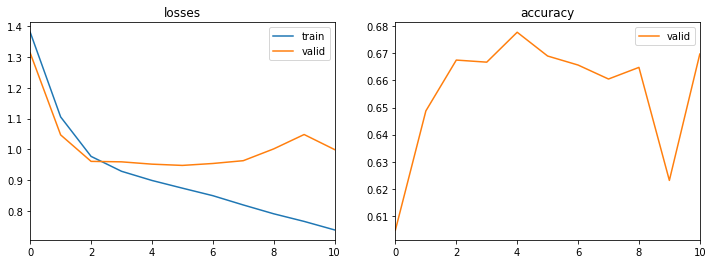

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 10, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.001, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 30}
LSTM_FCN                                                                                                               
 37%|████████████████▌                            | 11/30 [39:55<1:02:52, 198.55s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,1.869767,1.823779,0.095797,00:03
1,1.540694,1.443068,0.664543,00:03
2,1.281660,1.223921,0.664543,00:03
3,1.193935,1.158057,0.664543,00:03
4,1.151600,1.133448,0.664543,00:03
5,1.130957,1.121386,0.664543,00:03
6,1.124054,1.115155,0.664543,00:03
7,1.127188,1.111796,0.664543,00:03
8,1.115990,1.111969,0.664543,00:03
9,1.123413,1.110639,0.664543,00:03


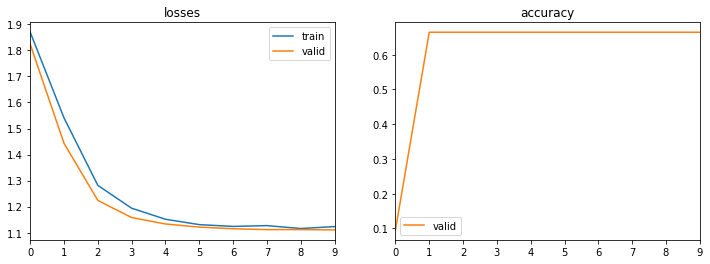

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 100, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.001, 'optimizer': <function Adam at 0x00000146BEB4C438>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 60}
LSTM_FCN                                                                                                               
 40%|██████████████████▊                            | 12/30 [40:59<47:26, 158.15s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,0.945677,0.949648,0.663530,00:14
1,0.877485,0.893408,0.677622,00:14
2,0.844387,0.892316,0.678346,00:14
3,0.818422,0.884276,0.679697,00:15
4,0.782015,0.914033,0.678925,00:15
5,0.743140,0.906989,0.666425,00:15
6,0.723527,0.970254,0.646735,00:15
7,0.681136,1.082031,0.677718,00:15
8,0.663212,1.297665,0.652816,00:15


No improvement since epoch 3: early stopping                                                                           
 40%|██████████████████▊                            | 12/30 [43:16<47:26, 158.15s/trial, best loss: 0.8457483649253845]

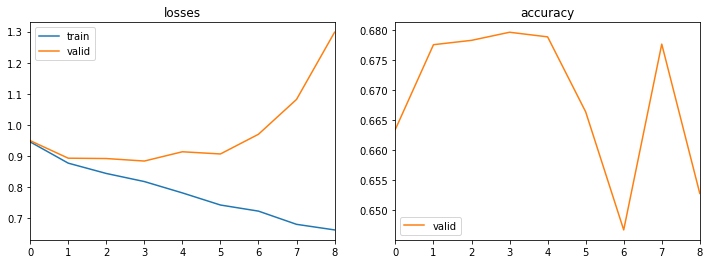

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 100, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x00000146BEB4C438>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 60}
LSTM_FCN                                                                                                               
 43%|████████████████████▎                          | 13/30 [43:48<45:30, 160.64s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,1.621509,1.660855,0.489986,00:15
1,1.276381,1.264300,0.605231,00:15
2,1.006439,0.992314,0.654457,00:15
3,0.965408,0.957141,0.659476,00:15
4,0.943338,0.932133,0.663771,00:15
5,0.915633,0.913336,0.669997,00:15
6,0.900055,0.903385,0.670093,00:15
7,0.882350,0.908164,0.670865,00:15
8,0.863540,0.876092,0.677236,00:15
9,0.857929,0.881510,0.677477,00:15


No improvement since epoch 12: early stopping                                                                          
 43%|████████████████████▎                          | 13/30 [49:44<45:30, 160.64s/trial, best loss: 0.8457483649253845]

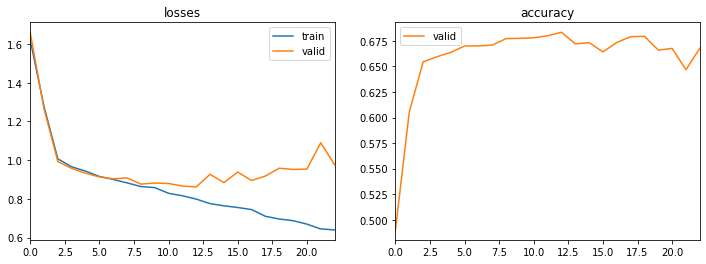

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 10, 'hidden_size': 50, 'kss': (11, 9, 7), 'lr': 0.1, 'optimizer': <function Adam at 0x00000146BEB4C438>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 60}
LSTM_FCN                                                                                                               
 47%|█████████████████████                        | 14/30 [50:17<1:01:01, 228.83s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,0.910932,0.925046,0.677718,00:03
1,0.873192,0.899170,0.686067,00:03
2,0.822832,1.020460,0.664495,00:03
3,0.772797,0.964934,0.648280,00:03
4,0.712314,1.146549,0.676319,00:03
5,0.646471,1.202707,0.666281,00:03
6,0.580541,1.320285,0.665171,00:03


No improvement since epoch 1: early stopping                                                                           
 47%|█████████████████████                        | 14/30 [50:42<1:01:01, 228.83s/trial, best loss: 0.8457483649253845]

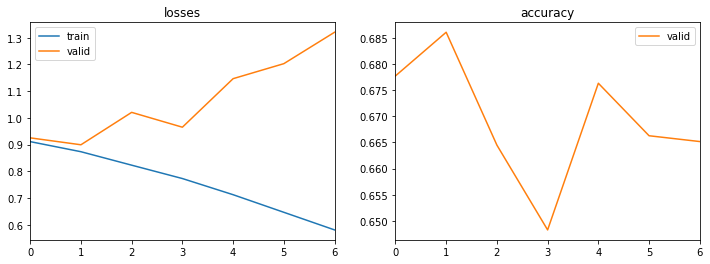

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function Adam at 0x00000146BEB4C438>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 30}
LSTM_FCN                                                                                                               
 50%|███████████████████████▌                       | 15/30 [51:13<44:19, 177.33s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,1.707915,1.701662,0.491193,00:04
1,1.551232,1.585580,0.549780,00:04
2,1.356301,1.355242,0.594952,00:04
3,1.104962,1.025516,0.656435,00:04
4,0.999876,0.977460,0.662323,00:04
5,0.965072,0.958929,0.668211,00:04
6,0.941144,0.955171,0.669031,00:04
7,0.920767,0.941463,0.673037,00:04
8,0.903321,0.953762,0.670141,00:04
9,0.887551,0.956793,0.675257,00:04


No improvement since epoch 10: early stopping                                                                          
 50%|███████████████████████▌                       | 15/30 [52:46<44:19, 177.33s/trial, best loss: 0.8457483649253845]

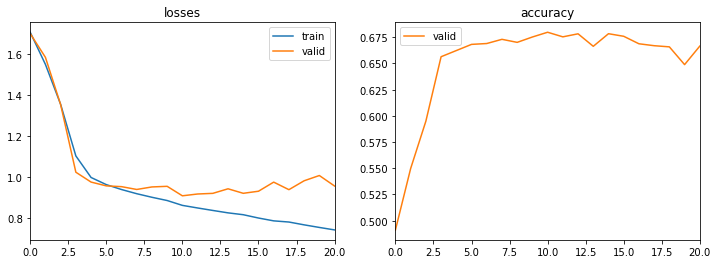

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.1, 'optimizer': <function RMSProp at 0x00000146BEB4C1F8>, 'patience': 5, 'rnn_layers': 4, 'time_steps': 30}
LSTM_FCN                                                                                                               
 53%|█████████████████████████                      | 16/30 [53:19<37:40, 161.43s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,0.987836,1.007821,0.654312,00:06
1,0.971618,1.008312,0.645432,00:06
2,0.961730,0.953282,0.672796,00:06
3,0.949554,1.090391,0.670672,00:06
4,0.936996,1.277135,0.644612,00:06
5,1.085973,0.980605,0.665653,00:06
6,0.934821,0.973962,0.676077,00:06
7,0.903482,0.986179,0.663626,00:06


No improvement since epoch 2: early stopping                                                                           
 53%|█████████████████████████                      | 16/30 [54:12<37:40, 161.43s/trial, best loss: 0.8457483649253845]

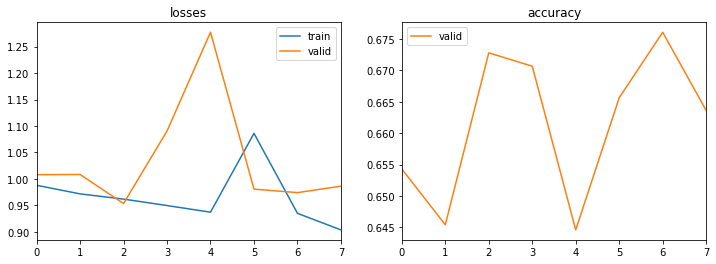

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 10, 'hidden_size': 100, 'kss': (11, 9, 7), 'lr': 0.1, 'optimizer': <function Adam at 0x00000146BEB4C438>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 60}
LSTM_FCN                                                                                                               
 57%|██████████████████████████▋                    | 17/30 [54:45<30:05, 138.92s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,0.934213,0.913585,0.669997,00:15
1,0.892295,0.903498,0.687032,00:15
2,0.851901,0.915815,0.679890,00:15
3,0.793965,1.237683,0.673954,00:15
4,0.727714,1.099236,0.668983,00:15
5,0.648600,1.227926,0.657835,00:14
6,0.558760,1.191588,0.657304,00:14
7,0.466314,1.383762,0.635008,00:15
8,0.364106,1.591846,0.644708,00:15
9,0.297353,1.732883,0.638821,00:14


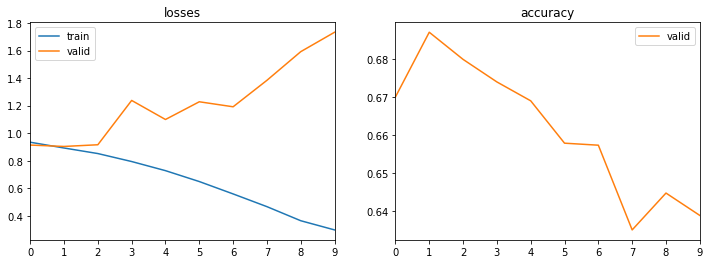

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 10, 'hidden_size': 50, 'kss': (11, 9, 7), 'lr': 0.01, 'optimizer': <function RMSProp at 0x00000146BEB4C1F8>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 60}
LSTM_FCN                                                                                                               
 60%|████████████████████████████▏                  | 18/30 [57:46<30:28, 152.37s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,0.923686,1.107393,0.642923,00:07
1,0.852057,0.987991,0.656098,00:07
2,0.740017,1.029547,0.670527,00:07
3,0.645754,1.191126,0.671589,00:08
4,0.551701,1.307342,0.670479,00:07
5,0.463961,1.361601,0.642247,00:07
6,0.377590,1.551188,0.605424,00:08
7,0.306708,1.716688,0.634332,00:08
8,0.254103,1.863614,0.631581,00:07
9,0.222136,1.847106,0.624487,00:08


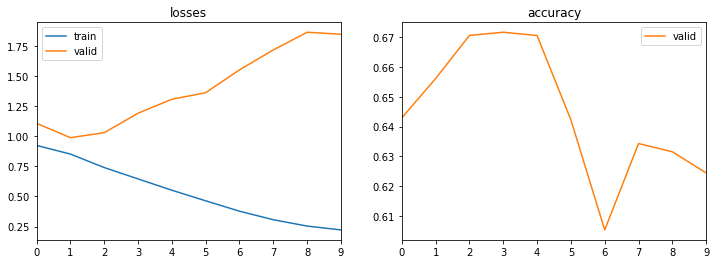

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 10, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 60}
LSTM_FCN                                                                                                               
 63%|█████████████████████████████▊                 | 19/30 [59:36<25:35, 139.63s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,1.138786,1.106423,0.664543,00:05
1,1.010163,1.024940,0.660634,00:06
2,0.952680,0.969841,0.657256,00:06
3,0.940222,0.946732,0.658752,00:06
4,0.917875,0.939938,0.660972,00:06
5,0.918881,0.923861,0.665267,00:06
6,0.912019,0.917342,0.666184,00:06
7,0.907936,0.915913,0.667728,00:06
8,0.903261,0.914609,0.668066,00:06
9,0.917055,0.914805,0.668163,00:06


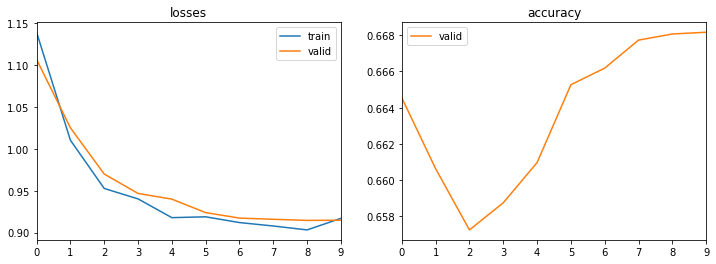

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 90}
LSTM_FCN                                                                                                               
 67%|██████████████████████████████               | 20/30 [1:01:08<20:52, 125.23s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,1.176712,1.127821,0.664543,00:22
1,1.091280,1.100269,0.664640,00:22
2,1.055189,1.077055,0.662854,00:23
3,1.012125,1.042324,0.658849,00:22
4,0.975056,0.999804,0.655905,00:23
5,0.952126,0.969464,0.655422,00:23
6,0.918828,0.948487,0.658173,00:22
7,0.911555,0.921893,0.664591,00:23
8,0.904622,0.905864,0.669997,00:24
9,0.895033,0.899307,0.677332,00:23


No improvement since epoch 17: early stopping                                                                          
 67%|██████████████████████████████               | 20/30 [1:10:04<20:52, 125.23s/trial, best loss: 0.8457483649253845]

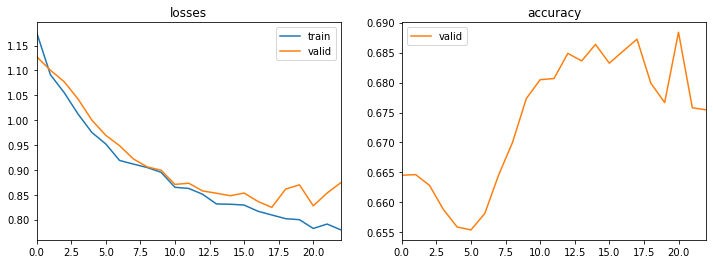

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 90}
LSTM_FCN                                                                                                               
 70%|███████████████████████████████▍             | 21/30 [1:10:35<38:37, 257.48s/trial, best loss: 0.8457483649253845]

epoch,train_loss,valid_loss,accuracy,time
0,1.154428,1.144278,0.664543,00:21
1,1.073550,1.107914,0.664447,00:23
2,1.042877,1.079660,0.662565,00:23
3,1.010932,1.044882,0.658462,00:22
4,0.967989,1.001139,0.656629,00:22
5,0.941131,0.974471,0.655663,00:23
6,0.919497,0.954359,0.656629,00:23
7,0.905808,0.935751,0.663868,00:24
8,0.896004,0.925406,0.668645,00:24
9,0.880087,0.901468,0.675884,00:24


No improvement since epoch 18: early stopping                                                                          
 70%|███████████████████████████████▍             | 21/30 [1:19:52<38:37, 257.48s/trial, best loss: 0.8457483649253845]

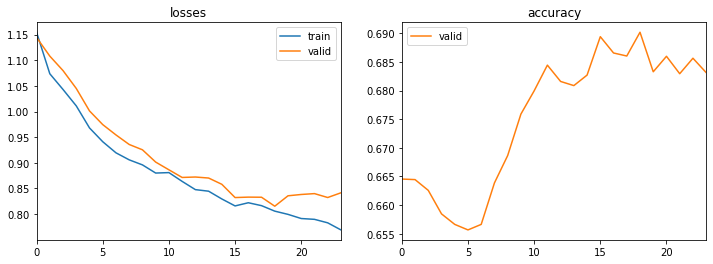

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 90}
LSTM_FCN                                                                                                               
 73%|█████████████████████████████████            | 22/30 [1:20:21<47:35, 356.90s/trial, best loss: 0.8416128158569336]

epoch,train_loss,valid_loss,accuracy,time
0,1.172752,1.135373,0.664543,00:33
1,1.100333,1.101281,0.664543,00:34
2,1.051093,1.082157,0.664398,00:34
3,1.009918,1.048456,0.660972,00:34
4,0.981210,1.008163,0.656870,00:35
5,0.944883,0.976586,0.655567,00:35
6,0.943362,0.956131,0.656580,00:35
7,0.916417,0.929990,0.662468,00:34
8,0.903981,0.912033,0.669852,00:35
9,0.883727,0.894084,0.675257,00:35


No improvement since epoch 16: early stopping                                                                          
 73%|█████████████████████████████████            | 22/30 [1:33:20<47:35, 356.90s/trial, best loss: 0.8416128158569336]

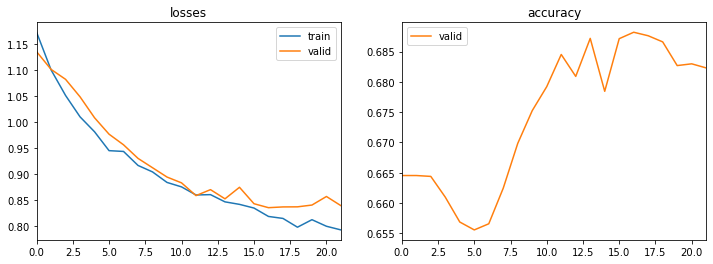

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 90}
LSTM_FCN                                                                                                               
 77%|██████████████████████████████████▌          | 23/30 [1:33:51<57:25, 492.15s/trial, best loss: 0.8390042185783386]

epoch,train_loss,valid_loss,accuracy,time
0,1.177098,1.136299,0.664543,00:22
1,1.098757,1.096488,0.664543,00:22
2,1.044649,1.071056,0.664640,00:23
3,1.008648,1.031096,0.659476,00:23
4,0.973575,0.996594,0.655277,00:23
5,0.937979,0.967353,0.655181,00:23
6,0.916116,0.940441,0.659283,00:23
7,0.910433,0.923810,0.664978,00:23
8,0.901980,0.912464,0.669466,00:23
9,0.891836,0.905293,0.673809,00:23


No improvement since epoch 19: early stopping                                                                          
 77%|██████████████████████████████████▌          | 23/30 [1:43:40<57:25, 492.15s/trial, best loss: 0.8390042185783386]

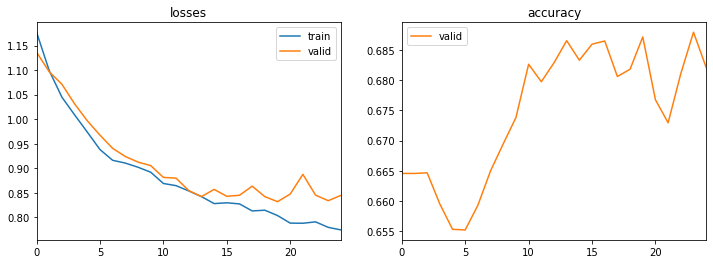

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 90}
LSTM_FCN                                                                                                               
 80%|████████████████████████████████████         | 24/30 [1:44:12<53:03, 530.53s/trial, best loss: 0.8390042185783386]

epoch,train_loss,valid_loss,accuracy,time
0,1.161643,1.125291,0.664543,00:34
1,1.075199,1.086152,0.664543,00:35
2,1.043394,1.065440,0.663481,00:35
3,1.012682,1.034921,0.659814,00:36
4,0.980770,0.998208,0.656098,00:36
5,0.942765,0.962294,0.656484,00:35
6,0.930360,0.940178,0.658849,00:36
7,0.912288,0.923876,0.662227,00:35
8,0.896242,0.911775,0.667535,00:35
9,0.884900,0.899227,0.674485,00:35


No improvement since epoch 22: early stopping                                                                          
 80%|████████████████████████████████████         | 24/30 [2:00:46<53:03, 530.53s/trial, best loss: 0.8390042185783386]

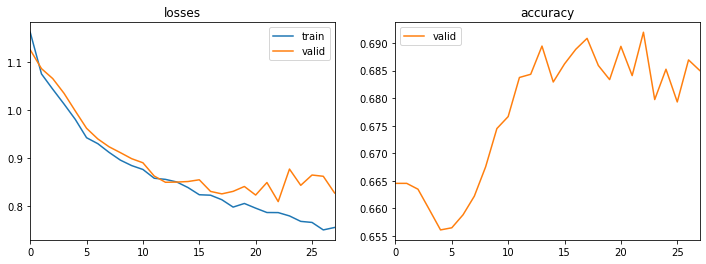

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 90}
LSTM_FCN                                                                                                               
 83%|█████████████████████████████████████▌       | 25/30 [2:01:15<56:35, 679.18s/trial, best loss: 0.8280870914459229]

epoch,train_loss,valid_loss,accuracy,time
0,1.175055,1.137399,0.664543,00:33
1,1.087935,1.098206,0.664543,00:34
2,1.046333,1.074583,0.662178,00:35
3,1.018420,1.042944,0.657835,00:35
4,0.970637,1.003160,0.654602,00:35
5,0.939630,0.971487,0.655181,00:35
6,0.924654,0.942640,0.657208,00:35
7,0.901340,0.925072,0.662854,00:35
8,0.886538,0.902981,0.672024,00:35
9,0.887381,0.899701,0.672024,00:35


No improvement since epoch 22: early stopping                                                                          
 83%|█████████████████████████████████████▌       | 25/30 [2:17:48<56:35, 679.18s/trial, best loss: 0.8280870914459229]

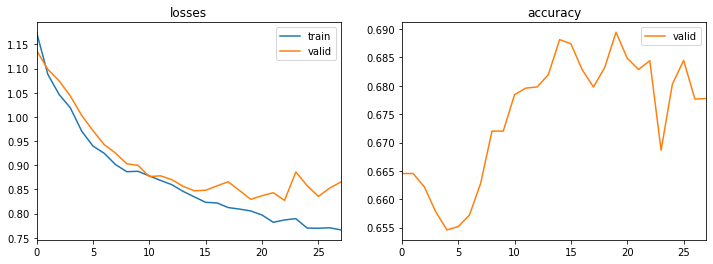

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 1, 'time_steps': 90}
LSTM_FCN                                                                                                               
 87%|███████████████████████████████████████      | 26/30 [2:18:16<52:07, 781.86s/trial, best loss: 0.8280870914459229]

epoch,train_loss,valid_loss,accuracy,time
0,1.185776,1.130958,0.664543,00:20
1,1.101693,1.092662,0.664543,00:21
2,1.052662,1.071573,0.664205,00:21
3,1.015312,1.037062,0.660055,00:21
4,0.979682,0.994903,0.656339,00:21
5,0.953761,0.966316,0.656146,00:21
6,0.925964,0.947068,0.658318,00:21
7,0.920369,0.923187,0.665074,00:21
8,0.903552,0.909283,0.667680,00:21
9,0.884327,0.902985,0.675691,00:21


No improvement since epoch 13: early stopping                                                                          
 87%|███████████████████████████████████████      | 26/30 [2:25:03<52:07, 781.86s/trial, best loss: 0.8280870914459229]

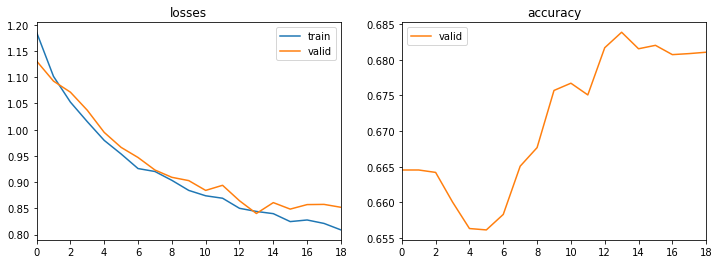

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 90}
LSTM_FCN                                                                                                               
 90%|████████████████████████████████████████▌    | 27/30 [2:25:31<33:53, 677.90s/trial, best loss: 0.8280870914459229]

epoch,train_loss,valid_loss,accuracy,time
0,1.180616,1.130192,0.664543,00:33
1,1.093263,1.095288,0.664543,00:35
2,1.054130,1.075516,0.664784,00:35
3,1.012972,1.041505,0.661310,00:36
4,0.991942,1.000008,0.656484,00:35
5,0.954006,0.975319,0.653829,00:36
6,0.927696,0.952979,0.655663,00:35
7,0.916368,0.931482,0.661358,00:36
8,0.905643,0.915359,0.665267,00:36
9,0.884665,0.904953,0.670576,00:36


No improvement since epoch 15: early stopping                                                                          
 90%|████████████████████████████████████████▌    | 27/30 [2:38:01<33:53, 677.90s/trial, best loss: 0.8280870914459229]

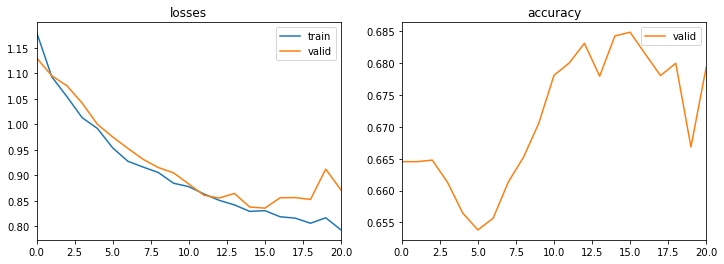

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 90}
LSTM_FCN                                                                                                               
 93%|██████████████████████████████████████████   | 28/30 [2:38:29<23:36, 708.03s/trial, best loss: 0.8280870914459229]

epoch,train_loss,valid_loss,accuracy,time
0,1.572655,1.415546,0.664543,00:31
1,1.296694,1.183026,0.664543,00:32
2,1.169680,1.122846,0.664543,00:32
3,1.110917,1.106440,0.664543,00:32
4,1.074984,1.094047,0.664495,00:32
5,1.050124,1.076333,0.663240,00:32
6,1.028897,1.056420,0.659958,00:32
7,1.005815,1.031783,0.657787,00:32
8,0.985141,1.004027,0.656484,00:33
9,0.964231,0.985851,0.654746,00:32


No improvement since epoch 33: early stopping                                                                          
 93%|██████████████████████████████████████████   | 28/30 [2:59:56<23:36, 708.03s/trial, best loss: 0.8280870914459229]

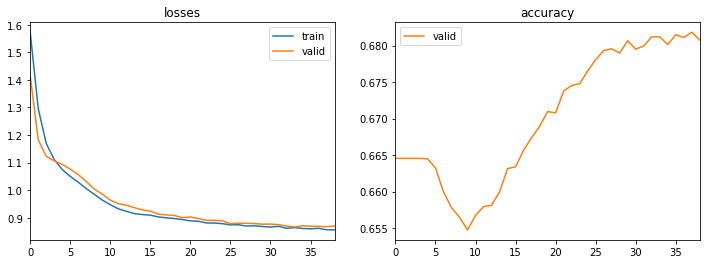

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 90}
LSTM_FCN                                                                                                               
 97%|███████████████████████████████████████████▌ | 29/30 [3:00:24<14:50, 890.03s/trial, best loss: 0.8280870914459229]

epoch,train_loss,valid_loss,accuracy,time
0,1.767787,1.772650,0.121616,00:18
1,1.758065,1.762601,0.132136,00:18
2,1.741202,1.743477,0.244969,00:19
3,1.714105,1.713151,0.479851,00:19
4,1.675846,1.671969,0.663578,00:19
5,1.628089,1.619710,0.664543,00:19
6,1.571104,1.558924,0.664543,00:19
7,1.507902,1.494427,0.664543,00:19
8,1.447367,1.431102,0.664543,00:18
9,1.392457,1.372807,0.664543,00:19


No improvement since epoch 41: early stopping                                                                          
 97%|███████████████████████████████████████████▌ | 29/30 [3:15:24<14:50, 890.03s/trial, best loss: 0.8280870914459229]

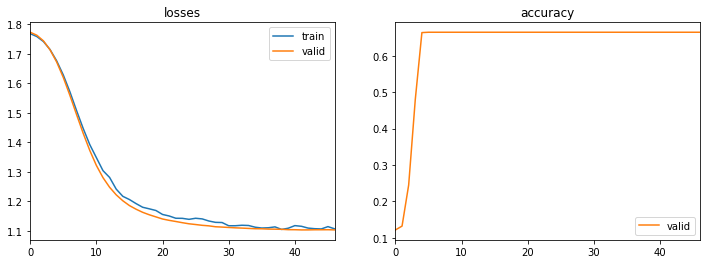

100%|█████████████████████████████████████████████| 30/30 [3:15:25<00:00, 390.84s/trial, best loss: 0.8280870914459229]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bidirectional': 0, 'bs': 0, 'conv_layers': 2, 'epochs': 1, 'hidden_size': 2, 'kss': 1, 'lr': 1, 'optimizer': 1, 'patience': 0, 'rnn_layers': 4, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 90}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = LSTM_FCN
    k = {
        'rnn_layers': params['rnn_layers'],
        'hidden_size': params['hidden_size'],
        'bidirectional': params['bidirectional'],
        'conv_layers': params['conv_layers'],
        'kss': params['kss']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x00000146BEB4C0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 90}
LSTM_FCN


epoch,train_loss,valid_loss,accuracy,time
0,1.172847,1.141730,0.664543,00:33
1,1.084419,1.102449,0.664543,00:35
2,1.059621,1.080708,0.662951,00:35
3,1.008964,1.043695,0.660152,00:36
4,0.978256,1.003128,0.656870,00:36
5,0.950581,0.974836,0.656532,00:36
6,0.940628,0.943779,0.659621,00:36
7,0.916534,0.925396,0.665219,00:35
8,0.903245,0.915312,0.669273,00:35
9,0.889684,0.893528,0.676029,00:36


No improvement since epoch 22: early stopping


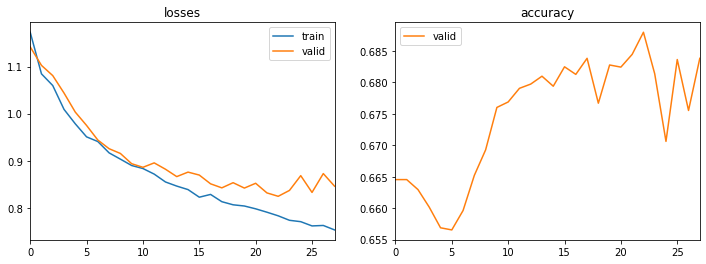

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[6.4591e-01, 2.1374e-01, 8.8113e-02, 4.0037e-02, 1.0819e-02, 1.3757e-03],
         [9.5282e-01, 3.6900e-02, 8.6325e-03, 1.2584e-03, 2.5439e-04, 1.3082e-04],
         [9.8636e-01, 1.2150e-02, 1.2853e-03, 1.8061e-04, 1.7159e-05, 2.8501e-06],
         ...,
         [9.9432e-01, 5.1573e-03, 4.5611e-04, 5.8764e-05, 6.8663e-06, 4.1150e-06],
         [9.9201e-01, 7.1419e-03, 7.2365e-04, 1.0193e-04, 1.3724e-05, 6.0817e-06],
         [9.6441e-01, 2.9179e-02, 5.2973e-03, 9.6735e-04, 1.2142e-04, 2.6232e-05]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.723977
f1 score:   0.692158


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_LSTM_FCN', y_test_true)
np.save('y_pred_LSTM_FCN', y_test_pred)